# Spam SMS Detection Project

## 1. Initial Data Exploration
First, let's examine the dataset to understand its structure, check for missing values, and get some basic statistics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

df = pd.read_csv("/kaggle/input/sms-spam-detection/spam.csv", encoding="latin1")


In [ ]:

df.head()
print("--INFO--")
print(df.info())
print("--NULL DETAILS--")
print(df.isnull().sum())
print("--DESCRIPTION--")
print(df.describe())
print("--SHAPE OF DATASET--")
df.shape

--INFO--
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None
--NULL DETAILS--
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64
--DESCRIPTION--
          v1                      v2  \
count   5572                    5572   
unique     2                    5169   
top      ham  Sorry, I'll call later   
freq    4825                      30   

                                               Unnamed: 2  \
count                                                  50   
unique                                                 43   
top      bt not his girlfrnd... G

(5572, 5)

## 2. Data Preparation
The dataset contains unnecessary columns. Let's keep only the relevant ones and rename them for clarity.

In [3]:
df.isnull().sum()
df = df.iloc[:, :2]
df.columns = ['label', 'message']

### 2.1 Reviewing Cleaned Data
Now let's look at our cleaned dataset with proper column names.

In [4]:
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## 3. Feature Engineering
### 3.1 Label Encoding
Converting categorical labels to numeric values: 'ham' to 0 and 'spam' to 1.

In [5]:
# Convert label from string to numeric 
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

### 3.2 Defining Features and Target
Separating the message text (features) from the spam/ham labels (target).

In [6]:
# Define features (X) and target (y)
X = df['message']  
y = df['label']    

### 3.3 Verifying Encoding
Checking that our label encoding worked correctly.

In [7]:
df

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


## 4. Text Vectorization
Converting text messages into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency).
This transforms our text data into a format that machine learning algorithms can process.

In [8]:
vectorizer = TfidfVectorizer(max_features=5000) 
X_vectorized = vectorizer.fit_transform(X)

## 5. Data Analysis
### 5.1 Class Distribution
Visualizing the imbalance between spam and ham messages in our dataset.

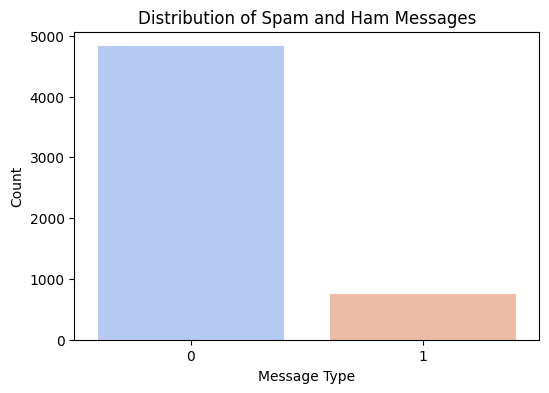

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'], palette='coolwarm')
plt.title("Distribution of Spam and Ham Messages")
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.show()


### 5.2 Handling Class Imbalance
Using SMOTE (Synthetic Minority Over-sampling Technique) to address the class imbalance by creating
synthetic examples of the minority class (spam).

In [10]:
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(X_vectorized, y)

### 5.3 Balanced Dataset Visualization
Verifying the effect of SMOTE on our class distribution.

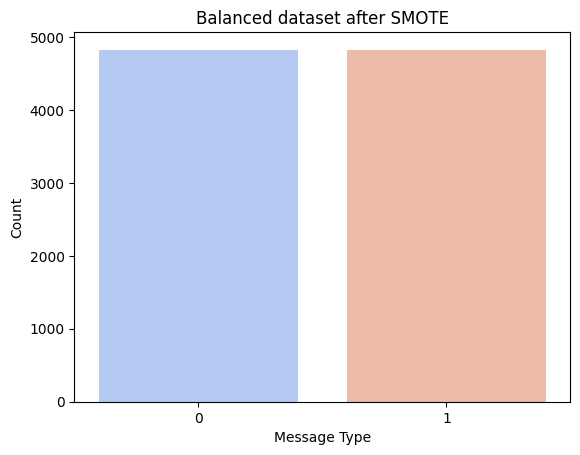

In [18]:
sns.countplot(x=y_resampled, palette='coolwarm')
plt.title("Balanced dataset after SMOTE")
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.show()

## 6. Train-Test Split
Splitting our data into training and testing sets, then applying SMOTE only to the training data
to avoid data leakage. We use a 80/20 split and stratify to maintain the same class distribution.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=0.2, random_state=42, stratify=y
)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Testing set shape: {X_test.shape}")

Original training set shape: (4457, 5000)
Resampled training set shape: (7718, 5000)
Testing set shape: (1115, 5000)


## 7. Model Training and Evaluation
Training multiple classification models and evaluating their performance:
- Naive Bayes
- Random Forest
- Logistic Regression
- Support Vector Machine (SVM)

For each model, we'll calculate:
- Accuracy
- Precision, Recall, and F1-Score
- Confusion Matrix

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

models = {
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name} model...")

    model.fit(X_train_resampled, y_train_resampled)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        "model": model,
        "accuracy": accuracy,
        "classification_report": classification_report(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

    print(f"{name} Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(results[name]["classification_report"])
    print("\nConfusion Matrix:")
    print(results[name]["confusion_matrix"])


Training Naive Bayes model...
Naive Bayes Accuracy: 0.9839

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.94      0.94      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix:
[[957   9]
 [  9 140]]

Training Random Forest model...
Random Forest Accuracy: 0.9803

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix:
[[966   0]
 [ 22 127]]

Training Logistic Regression model...
Logistic Regression Accuracy: 0.9839

Classificatio

## 8. Model Comparison
Creating visualizations to compare model performance and identifying the best model.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


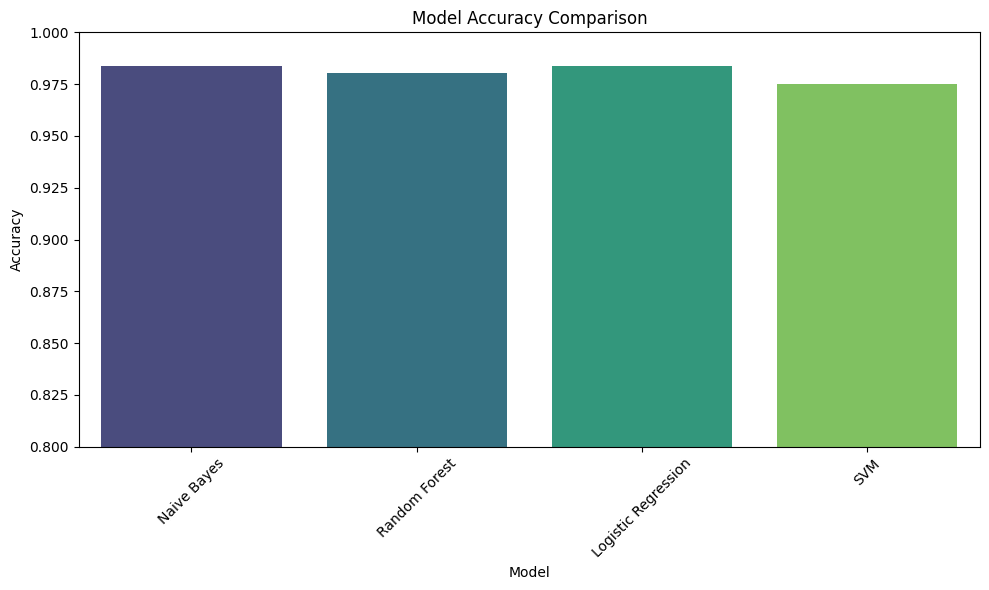

Best performing model: Naive Bayes with accuracy 0.9839


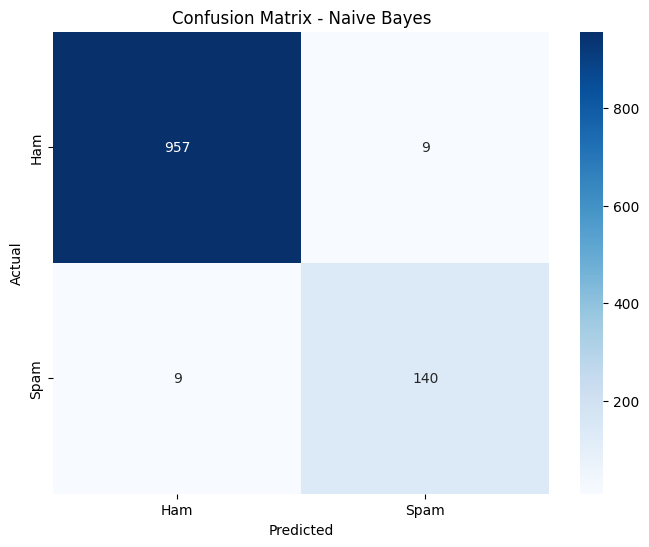

In [26]:
model_names = list(results.keys())
accuracies = [results[name]["accuracy"] for name in model_names]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0.8, 1.0) 
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()


best_model_name = max(results, key=lambda k: results[k]["accuracy"])
best_model = results[best_model_name]["model"]
best_accuracy = results[best_model_name]["accuracy"]

print(f"Best performing model: {best_model_name} with accuracy {best_accuracy:.4f}")

cm = results[best_model_name]["confusion_matrix"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.savefig(f"{best_model_name}_confusion_matrix.png")
plt.show()

## 9. Saving the Model
Saving the best performing model and the vectorizer for future use.

In [22]:
import pickle

def save_model(model, vectorizer, model_filename="best_model.pkl", vectorizer_filename="vectorizer.pkl"):
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    
    with open(vectorizer_filename, 'wb') as file:
        pickle.dump(vectorizer, file)
    
    print(f"Model saved as {model_filename}")
    print(f"Vectorizer saved as {vectorizer_filename}")

save_model(best_model, vectorizer, f"{best_model_name.lower().replace(' ', '_')}_model.pkl")

Model saved as naive_bayes_model.pkl
Vectorizer saved as vectorizer.pkl


## 10. Testing the Model
Testing our trained model with new example messages to verify it can correctly identify spam.

In [27]:
def predict_message(message, model, vectorizer):
    """
    Predict whether a new message is spam or not
    """
    
    message_vectorized = vectorizer.transform([message])
    

    prediction = model.predict(message_vectorized)[0]
    probability = model.predict_proba(message_vectorized)[0][1]
    

    return {
        "message": message,
        "prediction": "Spam" if prediction == 1 else "Ham",
        "spam_probability": probability
    }


example_messages = [
    "Congratulations! You've won a $1000 gift card. Call now to claim your prize!",
    "Hey, what time are we meeting for dinner tonight?",
    "URGENT: Your bank account has been compromised. Reply with your details to secure your account."
]

for message in example_messages:
    result = predict_message(message, best_model, vectorizer)
    print(f"\nMessage: {result['message']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Spam Probability: {result['spam_probability']:.4f}")


Message: Congratulations! You've won a $1000 gift card. Call now to claim your prize!
Prediction: Spam
Spam Probability: 0.9983

Message: Hey, what time are we meeting for dinner tonight?
Prediction: Ham
Spam Probability: 0.0073

Message: URGENT: Your bank account has been compromised. Reply with your details to secure your account.
Prediction: Spam
Spam Probability: 0.9229
